This notebook looks at how many "good" (R/B > 0.6) objects are found per COSMOS field image, and at how a candidate's average R/B score is correlated to the number of times it is detected.

In [1]:
import psycopg2
import psycopg2.extras
import getpass
from IPython.display import display
import ipywidgets
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
dbuser = input("DB User: ")
dbpasswd = getpass.getpass("DB Password: ")

DB User:  kennedyt
DB Password:  ············


In [3]:
db = psycopg2.connect(f"dbname='decat' user='{dbuser}' password='{dbpasswd}' host='decatdb.lbl.gov'")

In [4]:
db.autocommit = True # Makes the computer nicer about SQL syntax errors

cursor = db.cursor( cursor_factory = psycopg2.extras.DictCursor )

#### How many "Good" (R/B>0.6) sources are identified per subtraction? (COSMOS)

In [5]:
query = ( 'SELECT subtraction_id, id FROM objects o '
         'WHERE q3c_radial_query(o.ra,o.dec,150,2.2,3) '
         'AND o.rb>0.6 '
         'LIMIT 10000000')

cursor.execute( query )

subidobjid_a = np.array( cursor.fetchall() ).transpose()

In [6]:
# Find out how many objects are present in each subtraction (objspersub)
imgs, objspersub = np.unique( subidobjid_a[0], return_counts=True )

Median is 2 objects per subtraction
Mean is 3.055126 objects per subtraction
Max is 164 objects per subtraction
Min is 1 object(s) per subtraction


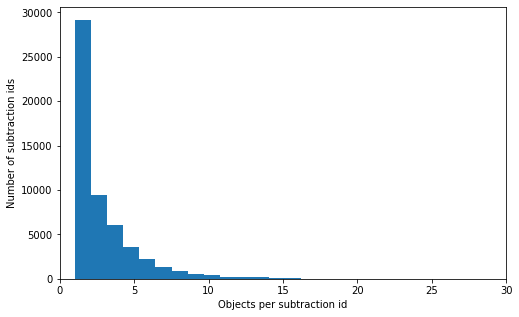

In [7]:
# Throw that data into a histogram
plt.figure( figsize=(8,5) )
plt.ylabel( "Number of subtraction ids" )
plt.xlabel( "Objects per subtraction id" )
plt.hist( objspersub, bins=150 )
plt.xlim( 0, 30 )
print( "Median is %i objects per subtraction" % ( np.median(objspersub) ) )
print( "Mean is %f objects per subtraction" % ( np.mean(objspersub) ) )
print( "Max is %i objects per subtraction" % ( np.max(objspersub) ) )
print( "Min is %i object(s) per subtraction" % ( np.min(objspersub) ) )

#### How many images have been processed so far? (COSMOS)

In [8]:
query = ( 'SELECT exposure_id FROM subtractions s '
         'WHERE q3c_radial_query(s.ra,s.dec,150,2.2,3) ' 
         'LIMIT 10000000' )

cursor.execute( query )

totsub = cursor.fetchall()

In [9]:
len( np.unique( totsub ) )

1117

#### How many exposures have been taken? (COSMOS)

In [10]:
query = ( 'SELECT COUNT(*) FROM exposures e '
         'WHERE q3c_radial_query(e.ra,e.dec,150,2.2,3) '
         'LIMIT 10000000' )

cursor.execute( query )

totexp = cursor.fetchall()[0][0]

In [11]:
totexp

1125

#### How many "Good" (R/B>0.6) sources are identified per exposure? (COSMOS)

In [12]:
query = ( 'SELECT o.subtraction_id, o.id, s.exposure_id FROM objects o '
         'JOIN subtractions s ON o.subtraction_id=s.id '
         'WHERE q3c_radial_query(o.ra,o.dec,150,2.2,3) ' 
         'AND o.rb>0.6 '
         'LIMIT 10000000' )

cursor.execute( query )

subidobjidexpid_a = np.array( cursor.fetchall() )

In [13]:
# Count frequencies of exposure IDs to find out how many objects come from each exposure
exp, objsperimg = np.unique( subidobjidexpid_a.transpose()[2], return_counts=True )

Median is 131 objects per exposure
Mean is 149.044763 objects per exposure
Max is 756 objects per exposure
Min is 12 object(s) per exposure


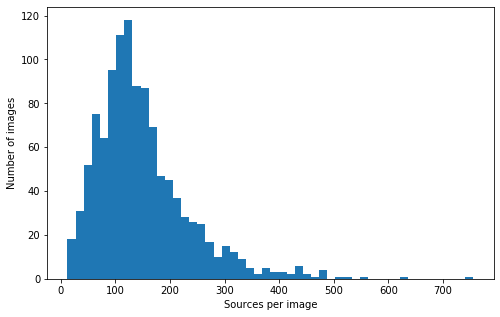

In [14]:
# Plotting
plt.figure( figsize=(8,5) )
plt.hist( objsperimg, bins=50 )
plt.xlabel( "Sources per image" )
plt.ylabel( "Number of images" );
print( "Median is %i objects per exposure" % ( np.median(objsperimg) ) )
print( "Mean is %f objects per exposure" % ( np.mean(objsperimg) ) )
print( "Max is %i objects per exposure" % ( np.max(objsperimg) ) )
print( "Min is %i object(s) per exposure" % ( np.min(objsperimg) ) )
plt.savefig("./images/srcsperimghist_COSMOS")

#### How are R/B scores associated with the number of times a candidate is detected? (COSMOS)

In [15]:
query = ( 'SELECT candidate_id, rb FROM objects o '
         'WHERE rb > 0.6 '
         'AND q3c_radial_query(o.ra,o.dec,150,2.2,3) '
         'LIMIT 10000000' )
cursor.execute( query )

cndrb_g = np.array( cursor.fetchall() ).transpose()

In [16]:
# Throw it into a DataFrame for easier sorting
cndrb_g_df = pd.DataFrame( cndrb_g.transpose(), columns=["Candidate ID", "RB score"] ).sort_values(by="Candidate ID")
cndrb_g_df

,Candidate ID,RB score
72775,DC21b,0.635156035423279
111282,DC21ba,0.696346163749695
47614,DC21baaa,0.719504654407501
39438,DC21baaa,0.746332168579102
38484,DC21baaa,0.776309758424759
...,...,...
108170,DC21zzv,0.787300318479538
51331,DC21zzv,0.702722370624542
98487,DC21zzv,0.988517642021179
11753,DC21zzv,0.732148230075836


In [17]:
len(np.unique(cndrb_g_df["Candidate ID"]))

56434

In [18]:
# Get a list of all unique candidates (candids) and the number of objects associated with each (numobjs)
candids, numobjs = np.unique( cndrb_g_df["Candidate ID"], return_counts=True )

# An array of R/B scores as floats instead of strings
rbs_raw = np.asarray( cndrb_g_df["RB score"].astype(np.float64) )

In [19]:
# This cell takes a minute or two to run
# It slices the R/B array into segments by candidate ID (using the number of objects per candidate determined earlier)
# Basically, if a candidate has n objects, it selects the next n R/B scores
# then takes a mean/median
rbs_mean = [ np.mean( rbs_raw[ np.sum(numobjs[0:i]):np.sum(numobjs[0:i+1]) ] ) for i in range(len( candids ))]
rbs_median = [ np.median( rbs_raw[ np.sum(numobjs[0:i]):np.sum(numobjs[0:i+1]) ] ) for i in range(len( candids ))]

 Each data point is one candidate, and detections with R/B < 0.6 are neglected


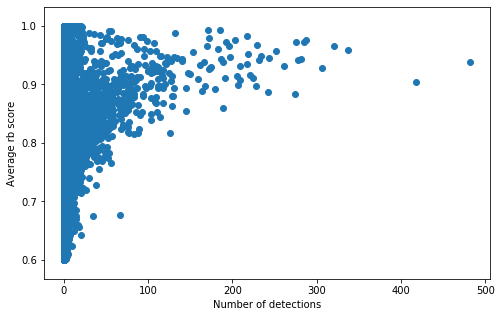

In [20]:
# Plotting the mean results
plt.figure( figsize=(8,5) )
plt.scatter( numobjs, rbs_mean )
plt.xlabel( "Number of detections" )
plt.ylabel( "Average rb score" )
print(" Each data point is one candidate, and detections with R/B < 0.6 are neglected" )
plt.savefig("./images/candrbVnum_COSMOS")

Each data point is one candidate, and detections with R/B < 0.6 are neglected


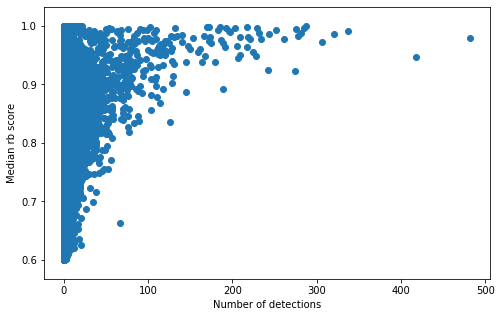

In [21]:
# Plotting the median results
plt.figure( figsize=(8,5) )
plt.scatter( numobjs, rbs_median )
plt.xlabel( "Number of detections" )
plt.ylabel( "Median rb score" )
print( "Each data point is one candidate, and detections with R/B < 0.6 are neglected" )